In [10]:
import os
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


from sklearn.metrics import classification_report, confusion_matrix


PROJECT_ROOT = "."   # notebook root
DATA_ROOT = os.path.join(PROJECT_ROOT, "data")  # matches current folder structure
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
SEED = 42

print("TensorFlow version:", tf.__version__)
print("Data root:", DATA_ROOT)

TensorFlow version: 2.18.0
Data root: .\data


In [3]:
pip install scikit-learn

   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------- ----------------------------- 2.4/8.7 MB 12.2 MB/s eta 0:00:01
   ------------------------ --------------- 5.2/8.7 MB 13.3 MB/s eta 0:00:01
   -------------------------------------- - 8.4/8.7 MB 13.7 MB/s eta 0:00:01
   ---------------------------------------- 8.7/8.7 MB 12.9 MB/s  0:00:00
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   -- ------------------------------------- 2.4/38.6 MB 12.2 MB/s eta 0:00:03
   ----- ---------------------------------- 5.2/38.6 MB 13.3 MB/s eta 0:00:03
   ------- -------------------------------- 7.6/38.6 MB 12.7 MB/s eta 0:00:03
   ----------- ---------------------------- 10.7/38.6 MB 13.2 MB/s eta 0:00:03
   -------------- ------------------------- 13.6/38.6 MB 13.2 MB/s eta 0:00:02
   ---------------- ----------------------- 16.3/38.6 MB 13.1 MB/s eta 0:00:02
   ------------------- -------------------- 19.1/38.6 MB 13.1 MB/s eta 0:00:02
   ---

In [11]:
#convert .jpg -> .jpeg and ensure RGB (run only if needed)
#cleaning code 

base_folder = DATA_ROOT
converted = 0
skipped = 0

for root, dirs, files in os.walk(base_folder):
    for filename in files:
        file_path = os.path.join(root, filename)
        ext = os.path.splitext(filename)[1].lower()
        # Only process .jpg files (your original choice)
        if ext == ".jpg":
            new_filename = os.path.splitext(filename)[0] + ".jpeg"
            new_path = os.path.join(root, new_filename)
            try:
                img = Image.open(file_path)
                # Convert images to RGB if necessary (JPEG needs RGB)
                if img.mode != "RGB":
                    img = img.convert("RGB")
                # Save as JPEG
                img.save(new_path, "JPEG")
                # Remove original .jpg file
                os.remove(file_path)
                converted += 1
                print(f"Converted {file_path} -> {new_path}")
            except Exception as e:
                print(f"Skipping {file_path} due to error: {e}")
                skipped += 1

print(f"Converted: {converted}, Skipped: {skipped}") 

Skipping .\data\train\edible\Cantharellus_cibarius_000012_1.jpg due to error: [WinError 32] The process cannot access the file because it is being used by another process: '.\\data\\train\\edible\\Cantharellus_cibarius_000012_1.jpg'
Skipping .\data\train\edible\Cantharellus_cibarius_000020_0.jpg due to error: [WinError 32] The process cannot access the file because it is being used by another process: '.\\data\\train\\edible\\Cantharellus_cibarius_000020_0.jpg'
Converted .\data\train\edible\Lentinula_edodes_000001_0.jpg -> .\data\train\edible\Lentinula_edodes_000001_0.jpeg
Converted .\data\train\edible\Russula_virescens_000012_1.jpg -> .\data\train\edible\Russula_virescens_000012_1.jpeg
Skipping .\data\train\poisonous\Galerina_marginata_000019_1.jpg due to error: [WinError 32] The process cannot access the file because it is being used by another process: '.\\data\\train\\poisonous\\Galerina_marginata_000019_1.jpg'
Skipping .\data\train\poisonous\Galerina_marginata_000022_0.jpg due to 

In [12]:
gpus = tf.config.experimental.list_physical_devices("GPU")

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [13]:
# Remove corrupted or tiny image files (< 10 KB)

min_size_kb = 10  # minimum size in KB

removed = 0
checked = 0

for root, dirs, files in os.walk(DATA_ROOT):
    for filename in files:
        file_path = os.path.join(root, filename)
        try:
            size_kb = os.path.getsize(file_path) / 1024
            checked += 1
            if size_kb < min_size_kb:
                os.remove(file_path)
                removed += 1
                print(f"Removed tiny file: {file_path} ({size_kb:.2f} KB)")
        except Exception as e:
            print(f"Error checking {file_path}: {e}")

print(f"Checked files: {checked}")
print(f"Removed tiny files (< {min_size_kb} KB): {removed}") 

Checked files: 2727
Removed tiny files (< 10 KB): 0


In [14]:
#Loading dataset


train_dir = os.path.join(DATA_ROOT, "train")
val_dir   = os.path.join(DATA_ROOT, "val")
test_dir  = os.path.join(DATA_ROOT, "test")

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
print("Class names (train):", class_names) 

Found 2180 files belonging to 2 classes.
Found 272 files belonging to 2 classes.
Found 275 files belonging to 2 classes.
Class names (train): ['edible', 'poisonous']


In [15]:
#converting the TensorFlow dataset (train_ds) into a NumPy-style iterator

data = train_ds            
data_iterator = data.as_numpy_iterator() 

In [16]:
data_iterator 

NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x000001EC16F61310>)

In [17]:
batch = data_iterator.next()    

In [18]:
batch
#print("batch[0].shape:", batch[0].shape)
#print("batch[1] (labels sample):", batch[1][:8])  

(array([[[[1.56047546e+02, 1.55047546e+02, 1.60047546e+02],
          [1.47748108e+02, 1.47779358e+02, 1.47732483e+02],
          [1.51770630e+02, 1.54130005e+02, 1.48411255e+02],
          ...,
          [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
          [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
          [2.55000000e+02, 2.55000000e+02, 2.55000000e+02]],
 
         [[1.54306580e+02, 1.53306580e+02, 1.58306580e+02],
          [1.54488647e+02, 1.56457397e+02, 1.55441772e+02],
          [1.62846008e+02, 1.63846008e+02, 1.58486633e+02],
          ...,
          [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
          [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
          [2.55000000e+02, 2.55000000e+02, 2.55000000e+02]],
 
         [[1.57646729e+02, 1.58435791e+02, 1.62541260e+02],
          [1.52865540e+02, 1.54834290e+02, 1.53818665e+02],
          [1.67698792e+02, 1.68055847e+02, 1.63017944e+02],
          ...,
          [2.55000000e+02, 2.55000000e+02, 2.5500

In [19]:
batch[0].shape  

(32, 256, 256, 3)

In [20]:
batch[1]  

array([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int32)

In [21]:
class_names = data.class_names
print(class_names)   

['edible', 'poisonous']


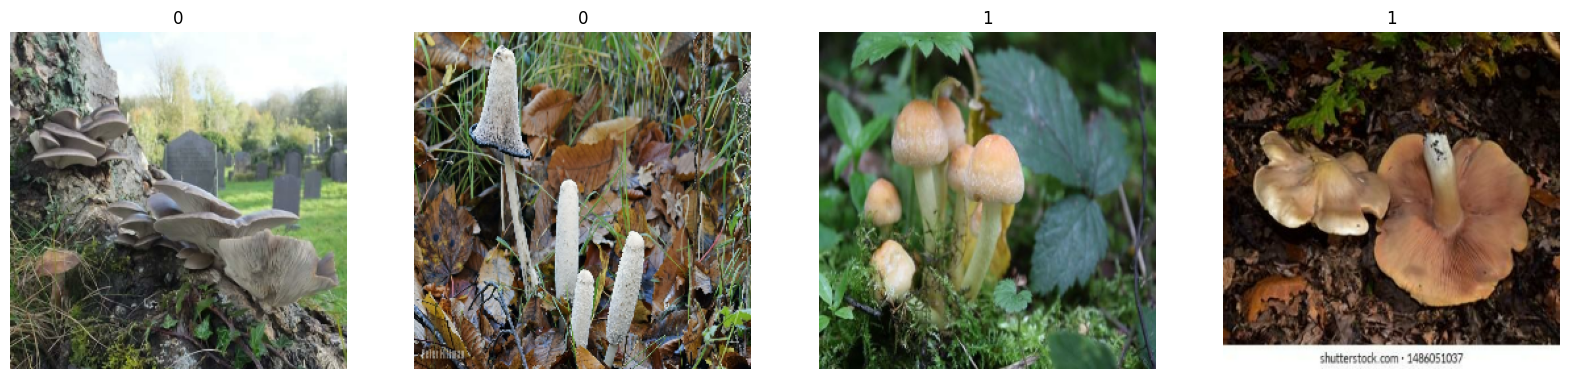

In [22]:
#Plotting 4 pictures 


fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].set_title(batch[1][idx])
    ax[idx].axis("off") 
plt.show() 

In [23]:
# x: images
# y: labels
# x / 255: scaled images--and NOT y : same labels 

scaled_data = data.map(lambda x, y: (x / 255, y))  

In [24]:
scaled_iterator = scaled_data.as_numpy_iterator()  

In [25]:
scaled_batch = scaled_iterator.next()  

In [26]:
scaled_batch[0].min()  

np.float32(0.0)

In [27]:
scaled_batch[0].max() 

np.float32(1.0)

### Split the data into train, validation and test

In [28]:
#Scale the data (images not labels)

scaled_train = train_ds.map(lambda x, y: (x / 255.0, y))
scaled_val = val_ds.map(lambda x, y: (x / 255.0, y))
scaled_test = test_ds.map(lambda x, y: (x / 255.0, y))


scaled_iterator = scaled_train.as_numpy_iterator()
scaled_batch = scaled_iterator.next()
print("scaled_batch range:", scaled_batch[0].min(), scaled_batch[0].max()) 

scaled_batch range: 0.0 1.0


In [11]:
train = scaled_train
val = scaled_val
test = scaled_test

#batch counts:
import tensorflow as _tf
train_batches = _tf.data.experimental.cardinality(train).numpy()
val_batches = _tf.data.experimental.cardinality(val).numpy()
test_batches = _tf.data.experimental.cardinality(test).numpy()
print("Batches -> train:", train_batches, "val:", val_batches, "test:", test_batches)

Batches -> train: 71 val: 9 test: 9


In [29]:
#Model definition 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, InputLayer

model = Sequential()

model.add(InputLayer(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))

# 16 filters
model.add(Conv2D(16, (3,3), strides=1, activation="relu", padding="same"))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

# 32 filters
model.add(Conv2D(32, (3,3), strides=1, activation="relu", padding="same"))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

# 64 filters
model.add(Conv2D(64, (3,3), strides=1, activation="relu", padding="same"))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

# Flatten the model 
model.add(Flatten())

model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))


model.add(Dense(1, activation="sigmoid")) 

C:\Users\carhol\venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [30]:
model.compile(optimizer="adam", loss=tf.losses.BinaryCrossentropy(), metrics=["accuracy"]) 

In [31]:
model.summary() 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      16,777,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,801,313 (64.09 MB)

 Trainable params: 16,801,313 (64.09 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
import imghdr
from PIL import Image


for split in ("train", "val", "test"):
    folder = os.path.join(DATA_ROOT, split)
    for root, dirs, files in os.walk(folder):
        for fname in files:
            fpath = os.path.join(root, fname)
            try:
                #Removing files with no detectable image format
                if imghdr.what(fpath) is None:
                    os.remove(fpath)
                    print("Removed invalid image:", fpath)
                    continue

                #Removing corrupted images (PIL verify)
                with Image.open(fpath) as img:
                    img.verify()

            except Exception:
                os.remove(fpath)
                print("Removed corrupted image:", fpath)

#reloading the dataset after cleaning process
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_ROOT, "train"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_ROOT, "val"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_ROOT, "test"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

#Scaling the images
train = train_ds.map(lambda x, y: (x / 255.0, y))
val   = val_ds.map(lambda x, y: (x / 255.0, y))
test  = test_ds.map(lambda x, y: (x / 255.0, y))

#train the model
trained_model = model.fit(
    train,
    epochs=20,
    validation_data=val
)


Found 2180 files belonging to 2 classes.
Found 272 files belonging to 2 classes.
Found 275 files belonging to 2 classes.
Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 60s 814ms/step - accuracy: 0.5197 - loss: 1.0886 - val_accuracy: 0.5294 - val_loss: 0.6796
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 54s 772ms/step - accuracy: 0.5404 - loss: 0.6793 - val_accuracy: 0.5846 - val_loss: 0.6605
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 50s 718ms/step - accuracy: 0.6179 - loss: 0.6569 - val_accuracy: 0.6250 - val_loss: 0.6399
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 49s 707ms/step - accuracy: 0.6555 - loss: 0.6293 - val_accuracy: 0.7096 - val_loss: 0.6058
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 53s 756ms/step - accuracy: 0.7358 - loss: 0.5409 - val_accuracy: 0.6949 - val_loss: 0.5764
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 49s 701ms/step - accuracy: 0.7922 - loss: 0.4358 - val_accuracy: 0.7794 - val_loss: 0.4672
Epoch 7/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 53s 758ms/step - accuracy: 0.8578 - loss: 0.3245 - val_accuracy: 0.

In [37]:
print(data.class_names) 

['edible', 'poisonous']


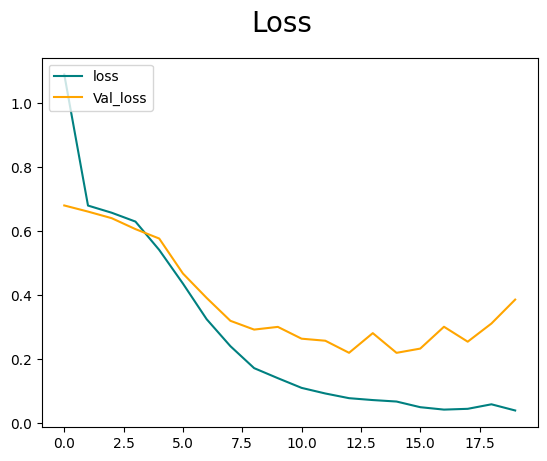

In [38]:
fig = plt.figure()
plt.plot(trained_model.history["loss"], color="teal", label="loss")
plt.plot(trained_model.history["val_loss"], color="orange", label="Val_loss")
fig.suptitle("Loss", fontsize=20)
plt.legend(loc="upper left")
plt.show() 

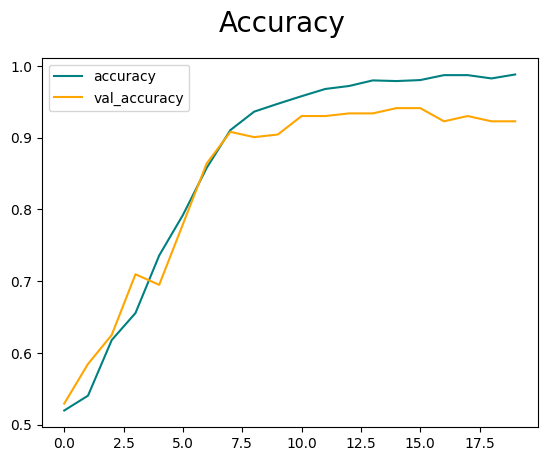

In [39]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(trained_model.history['accuracy'], color='teal', label='accuracy')
plt.plot(trained_model.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show() 

### Evaluate

In [40]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy 

In [41]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy() 

In [42]:
len(test)

9

In [43]:
for batch in test.as_numpy_iterator():
    X, y = batch
    y_pred = model.predict(X)

    precision.update_state(y, y_pred)
    recall.update_state(y, y_pred)
    accuracy.update_state(y, y_pred) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


In [44]:
print(f"Precision: {precision.result().numpy()}, "
      f"Recall: {recall.result().numpy()}, "
      f"Accuracy: {accuracy.result().numpy()}")

Precision: 0.8712121248245239, Recall: 0.8984375, Accuracy: 0.8909090757369995


In [45]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

#train
precision_train = Precision()
recall_train = Recall()
accuracy_train = BinaryAccuracy()

for batch in train.as_numpy_iterator():
    X, y = batch
    y_pred = model.predict(X, verbose=0)
    precision_train.update_state(y, y_pred)
    recall_train.update_state(y, y_pred)
    accuracy_train.update_state(y, y_pred)

print("Train Precision:", precision_train.result().numpy())
print("Train Recall:", recall_train.result().numpy())
print("Train Accuracy:", accuracy_train.result().numpy())


#validation
precision_val = Precision()
recall_val = Recall()
accuracy_val = BinaryAccuracy()

for batch in val.as_numpy_iterator():
    X, y = batch
    y_pred = model.predict(X, verbose=0)
    precision_val.update_state(y, y_pred)
    recall_val.update_state(y, y_pred)
    accuracy_val.update_state(y, y_pred)

print("Validation Precision:", precision_val.result().numpy())
print("Validation Recall:", recall_val.result().numpy())
print("Validation Accuracy:", accuracy_val.result().numpy())


#test
precision_test = Precision()
recall_test = Recall()
accuracy_test = BinaryAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    y_pred = model.predict(X, verbose=0)
    precision_test.update_state(y, y_pred)
    recall_test.update_state(y, y_pred)
    accuracy_test.update_state(y, y_pred)

print("Test Precision:", precision_test.result().numpy())
print("Test Recall:", recall_test.result().numpy())
print("Test Accuracy:", accuracy_test.result().numpy()) 

Train Precision: 0.9980526
Train Recall: 0.99902534
Train Accuracy: 0.99862385
Validation Precision: 0.90076333
Validation Recall: 0.93650794
Validation Accuracy: 0.9227941
Test Precision: 0.8712121
Test Recall: 0.8984375
Test Accuracy: 0.8909091
